In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

cbf_colors = [
    '#0072B2',  # Blue
    '#009E73',  # Green
    '#CC79A7',  # Reddish purple
    '#F0E442',  # Yellow
    '#56B4E9',  # Light blue
    '#E69F00',  # Orange
    '#D55E00',  # Vermillion
    '#000000'   # Black
]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cbf_colors)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

In [2]:
def stick_break_single_sample(beta_row):
    '''
    Convert Beta(1, alpha) draws to mixing proportions pi_k using
    truncated stick-breaking. Used on a single MCMC sample's beta_row.
    '''
    pi_list = []
    prod = 1.0
    for b_ in beta_row:
        part_ = b_ * prod
        pi_list.append(part_)
        prod *= (1.0 - b_)
    pi_list.append(prod)
    return np.array(pi_list)

def warburg_arc_impedance(freq_array, log_tau0, alpha):
    """
    Warburg partial arc:
      Z_W = 1 / [ (j * 2π f * tau0)^alpha ].
    alpha is drawn from posterior for each MCMC sample.
    """
    tau0 = np.exp(log_tau0)
    omega = 2.0 * np.pi * freq_array
    return 1.0 / ((1j * omega * tau0) ** alpha)

def warburg_arc_gamma(tau_array, log_tau0, alpha):
    """
    Warburg partial DRT with alpha from posterior:
      gamma_W(tau) = (1/π) sin(απ) (τ / tau0)^α.
    """
    tau0 = np.exp(log_tau0)
    return (1.0 / np.pi) * np.sin(alpha * np.pi) * (tau_array / tau0)**alpha

# HN arc (Impedance & DRT) remains the same
def hn_arc_impedance(freq_array, amplitude, phi, alpha, tau0):
    """
    Single HN arc:
      Z_k = amplitude / [1 + (j * 2π f * tau0)^phi]^alpha.
    """
    omega = 2.0 * np.pi * freq_array
    return amplitude / ((1.0 + (1j * omega * tau0)**phi) ** alpha)

def _theta_HN(tau_array, tau0, phi):
    return np.arctan2(
        np.sin(np.pi * phi),
        ((tau_array / tau0)**phi + np.cos(np.pi * phi))
    )

def hn_arc_gamma(tau_array, amplitude, phi, alpha, tau0):
    """
    Single HN arc DRT:
      gamma(tau) = amplitude/pi * [ ((tau/tau0)^(alpha*phi) * sin(alpha*theta_HN)) /
        (1 + 2 cos(pi phi)(tau/tau0)^phi + (tau/tau0)^(2 phi))^(alpha/2) ]
    """
    ratio_phi = (tau_array / tau0)**phi
    theta_val = _theta_HN(tau_array, tau0, phi)
    prefactor = amplitude / np.pi

    numerator = ratio_phi**(alpha * phi) * np.sin(alpha * theta_val)
    denominator = (1.0 + 2.0*np.cos(np.pi*phi)*ratio_phi + ratio_phi**2)**(alpha/2.0)
    return prefactor * (numerator / denominator)

In [3]:
def compute_posterior_arcs_warburg_hn(
    freq_vec,
    tau_vec,
    posterior_samples,
    K_w=5,
    K_hn=5
):
    """
    For each MCMC sample (from the combined DP-Warburg-HN model),
    compute partial arcs (Warburg + HN) in impedance & DRT, plus total.

    Warburg arcs:
      alpha_w = posterior_samples['alpha_w'][i] for sample i (shared by all Warburg arcs in that sample).
      Z_k_w = pi_w[k_idx] * (1 / [(j*omega*tau0_w[k_idx])^alpha_w]),
      gamma_k_w = pi_w[k_idx] * (1/π) sin(α_w π) (τ/τ0_w)^{α_w}, etc.

    HN arcs:
      Z_k_hn = pi_hn[m_idx] * w_hn[m_idx] / [1+(j omega tau0)^phi]^alpha, etc.
    """
    R_inf_samps      = posterior_samples['R_inf']
    p_w_samps        = posterior_samples['p_W_fraction']

    alpha_w_samps    = posterior_samples['alpha_w']  # single alpha per sample #FC
    beta_w_samps     = posterior_samples['beta_w']
    log_tau0_w_samps = posterior_samples['log_tau0_w']  # shape (#samples, K_w)

    alpha_hn_samps   = posterior_samples['alpha_hn']
    beta_hn_samps    = posterior_samples['beta_hn']
    w_hn_samps       = posterior_samples['w_hn']
    phi_hn_samps     = posterior_samples['phi_hn']
    alpha_arc_samps  = posterior_samples['alpha_hn_arcs']
    log_tau0_hn_samps= posterior_samples['log_tau0_hn']

    n_samps = R_inf_samps.shape[0]

    all_arcs_imp_w  = []
    all_arcs_gamma_w= []
    all_arcs_imp_hn = []
    all_arcs_gamma_hn= []
    sum_impedance   = []
    sum_gamma       = []

    for i in range(n_samps):
        #--- global R_inf
        R_inf_ = R_inf_samps[i]

        #--- Warburg mixture weights
        beta_w_  = beta_w_samps[i]
        pi_w_raw = stick_break_single_sample(beta_w_)
        pi_w_    = pi_w_raw * p_w_samps[i]

        #--- HN mixture weights
        beta_hn_  = beta_hn_samps[i]
        pi_hn_raw = stick_break_single_sample(beta_hn_)
        pi_hn_    = pi_hn_raw * (1.0 - p_w_samps[i])

        # Warburg arcs:
        log_tau0_wi = log_tau0_w_samps[i]  # shape (K_w,)
        alpha_w_i   = alpha_w_samps[i]     # single alpha for Warburg arcs #FC

        # HN arcs:
        w_hn_i      = w_hn_samps[i]        # shape (K_hn,)
        phi_hn_i    = phi_hn_samps[i]      # shape (K_hn,)
        alpha_arc_i = alpha_arc_samps[i]   # shape (K_hn,)
        log_tau0_hi = log_tau0_hn_samps[i] # shape (K_hn,)

        arcZ_w_list = []
        arcG_w_list = []
        arcZ_hn_list= []
        arcG_hn_list= []

        #--- Build partial Warburg arcs
        for k_idx in range(K_w):
            # Warburg arc for that k_idx, scaled by pi_w_[k_idx]
            Z_k_w  = warburg_arc_impedance(freq_vec, log_tau0_wi[k_idx], alpha_w_i)  #FC
            G_k_w  = warburg_arc_gamma(tau_vec,      log_tau0_wi[k_idx], alpha_w_i)  #FC

            # Weighted by pi_w:
            Z_k_w_weighted = pi_w_[k_idx] * Z_k_w
            G_k_w_weighted = pi_w_[k_idx] * G_k_w

            arcZ_w_list.append(Z_k_w_weighted)
            arcG_w_list.append(G_k_w_weighted)

        #--- Build partial HN arcs
        for m_idx in range(K_hn):
            amplitude_m = pi_hn_[m_idx] * w_hn_i[m_idx]
            phi_m       = phi_hn_i[m_idx]
            alpha_m     = alpha_arc_i[m_idx]
            tau0_m      = np.exp(log_tau0_hi[m_idx])

            Z_m_hn = hn_arc_impedance(freq_vec, amplitude_m, phi_m, alpha_m, tau0_m)
            G_m_hn = hn_arc_gamma(tau_vec, amplitude_m, phi_m, alpha_m, tau0_m)

            arcZ_hn_list.append(Z_m_hn)
            arcG_hn_list.append(G_m_hn)

        arcsZ_w  = np.stack(arcZ_w_list,  axis=0)
        arcsG_w  = np.stack(arcG_w_list,  axis=0)
        arcsZ_hn = np.stack(arcZ_hn_list, axis=0)
        arcsG_hn = np.stack(arcG_hn_list, axis=0)

        sum_Z = (np.sum(arcsZ_w, axis=0)
                 + np.sum(arcsZ_hn, axis=0)
                 + R_inf_)
        sum_G = np.sum(arcsG_w, axis=0) + np.sum(arcsG_hn, axis=0)

        all_arcs_imp_w.append(arcsZ_w)
        all_arcs_gamma_w.append(arcsG_w)
        all_arcs_imp_hn.append(arcsZ_hn)
        all_arcs_gamma_hn.append(arcsG_hn)
        sum_impedance.append(sum_Z)
        sum_gamma.append(sum_G)

    all_arcs_imp_w   = np.stack(all_arcs_imp_w,   axis=0)
    all_arcs_gamma_w = np.stack(all_arcs_gamma_w, axis=0)
    all_arcs_imp_hn  = np.stack(all_arcs_imp_hn,  axis=0)
    all_arcs_gamma_hn= np.stack(all_arcs_gamma_hn,axis=0)
    sum_impedance    = np.stack(sum_impedance,    axis=0)
    sum_gamma        = np.stack(sum_gamma,        axis=0)

    return (all_arcs_imp_w, all_arcs_gamma_w, all_arcs_imp_hn, all_arcs_gamma_hn, sum_impedance, sum_gamma)

Loads the frequency data, impedance data, exact references, tau array, exact gamma, and posterior samples from the HN-based analysis.

In [4]:
# Posterior samples
results_dir='dp_hn_results'
posterior_data = np.load(os.path.join(results_dir, 'posterior_samples.npy'), allow_pickle=True).item()

# Convert the posterior dictionary entries to arrays
posterior_samples = {}
for k, v in posterior_data.items():
    posterior_samples[k] = v

# EIS data and references
freq_vec     = np.load(os.path.join(results_dir, 'freq_vec.npy'))
Z_exp        = np.load(os.path.join(results_dir, 'Z_exp.npy'))
Z_exact      = np.load(os.path.join(results_dir, 'Z_exact.npy'))
tau_vec      = np.load(os.path.join(results_dir, 'tau_vec.npy'))
gamma_exact  = np.load(os.path.join(results_dir, 'gamma_exact.npy'))

In [5]:
(all_arcs_imp_w, all_arcs_gamma_w, all_arcs_imp_hn, all_arcs_gamma_hn, sum_of_arcs_impedance, sum_of_arcs_gamma) = compute_posterior_arcs_warburg_hn(freq_vec, tau_vec, posterior_samples, K_w=10, K_hn=10)

# Posterior mean for standard DRT plots
arcs_mean_w  = np.mean(all_arcs_gamma_w, axis=0)  # shape (K_w,  N_tau)
arcs_mean_hn = np.mean(all_arcs_gamma_hn, axis=0) # shape (K_hn, N_tau)
arcs_fit_mean_total = np.concatenate([arcs_mean_w, arcs_mean_hn], axis=0)  # shape (K_w+K_hn, N_tau)
gamma_sum_mean = np.mean(sum_of_arcs_gamma, axis=0)


Plots the mean partial arcs and total DRT, with an option to overlay the exact DRT.

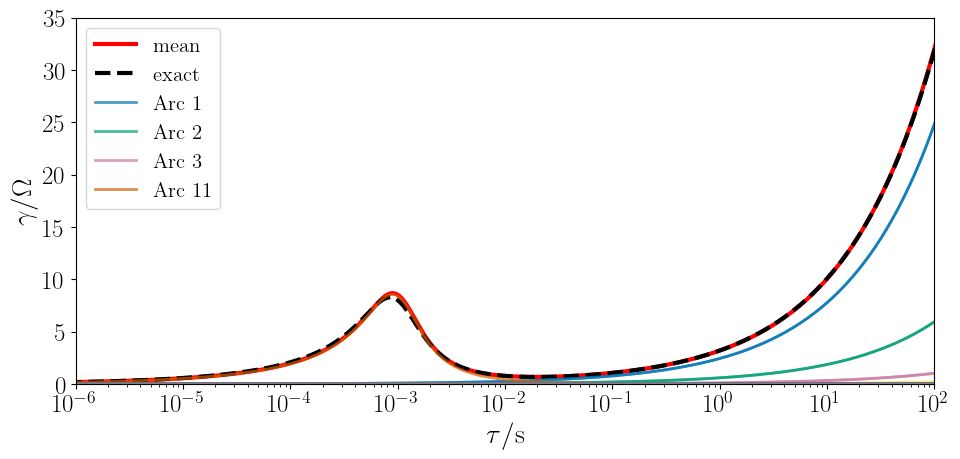

In [10]:
plt.figure(figsize=(10,5))
plt.semilogx(tau_vec, gamma_sum_mean, 'r-', linewidth=3, label='mean')
if gamma_exact is not None:
    plt.semilogx(tau_vec, gamma_exact, 'k--', linewidth=3, label='exact')
for k in range(arcs_fit_mean_total.shape[0]):
    if k in [0,1,2]:
        plt.semilogx(tau_vec, arcs_fit_mean_total[k], linewidth=2, alpha=0.7, color=cbf_colors[k], label=f'Arc {k+1}')
    if k == 10:
        plt.semilogx(tau_vec, arcs_fit_mean_total[k], linewidth=2, alpha=0.7, color=cbf_colors[6], label=f'Arc {k+1}')
    else:
        plt.semilogx(tau_vec, arcs_fit_mean_total[k], linewidth=2, alpha=0.7)

plt.xlabel(r'$\tau/\rm s$')
plt.ylabel(r'$\gamma/\Omega$')
plt.legend(frameon=True, framealpha=0.75, fontsize=15)
plt.xlim(1e-6,1e2)
plt.ylim(0.0, 35)
# plt.title('DRT Components (Mean)')
plt.tight_layout()

# Save plots
# plt.savefig('gamma_components.png', format='png', dpi=300)
# plt.savefig('gamma_components.svg',)
plt.show()

Plots credible intervals (5%-95% and 25%-75%) of the total DRT, with an option to overlay an exact reference DRT.

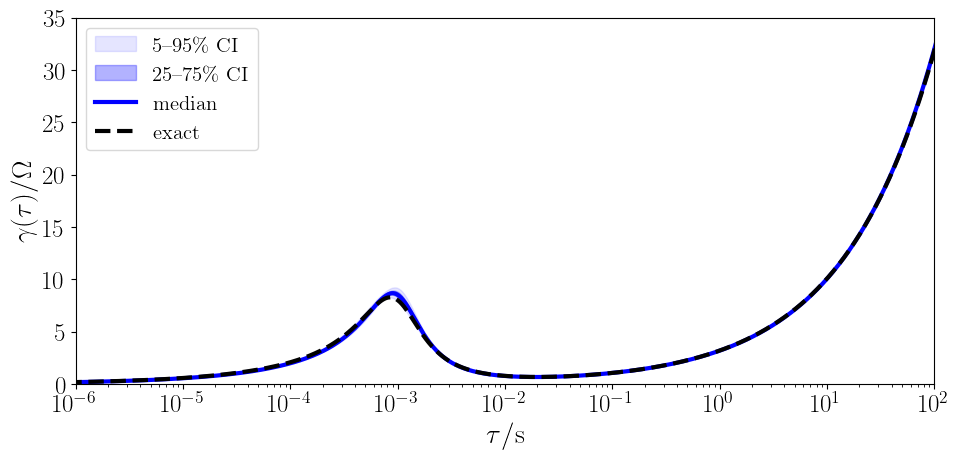

In [11]:
pct_vals = np.percentile(sum_of_arcs_gamma, [5, 25, 50, 75, 95], axis=0)
g5, g25, g50, g75, g95 = pct_vals

plt.figure(figsize=(10,5))
plt.fill_between(tau_vec, g5, g95, alpha=0.1, color='blue', label='5--95\\% CI')
plt.fill_between(tau_vec, g25, g75, alpha=0.3, color='blue', label='25--75\\% CI')
plt.semilogx(tau_vec, g50, 'b-', linewidth=3, label='median')
if gamma_exact is not None:
    plt.semilogx(tau_vec, gamma_exact, 'k--', linewidth=3, label='exact')
plt.xlabel(r'$\tau/\rm s$')
plt.ylabel(r'$\gamma(\tau)/\Omega$')
plt.xlim(1e-6,1e2)
plt.ylim(0.0, 35)
# plt.grid(True, which='both', alpha=0.3)
plt.legend(frameon=True, framealpha=0.75, fontsize=15)
# plt.title('Posterior Credible Intervals for Total DRT')
plt.tight_layout()

# plt.savefig('gamma_intervals.png', format='png', dpi=300)
# plt.savefig('gamma_intervals.svg',)
plt.show()

Nyquist plot of noisy data, exact model, and MCMC posterior mean.

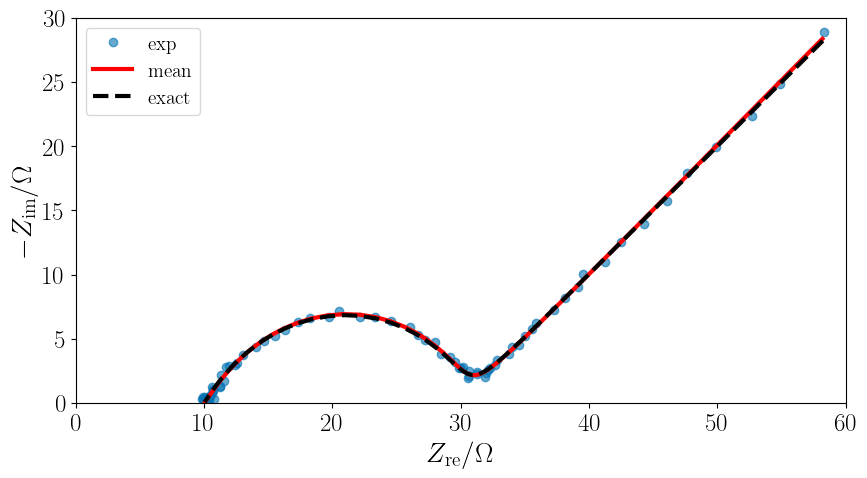

In [12]:
plt.figure(figsize=(10, 5))
# Plot the noisy experimental data
plt.plot(Z_exp.real, -Z_exp.imag, 'o', label='exp', alpha=0.6)
# Compute and plot the posterior mean
Z_mean = np.mean(sum_of_arcs_impedance, axis=0)
plt.plot(Z_mean.real, -Z_mean.imag, 'r-', label='mean', linewidth=3)
# Plot the exact noise-free data
plt.plot(Z_exact.real, -Z_exact.imag, 'k--', label='exact', linewidth=3)
# Label axes
plt.xlabel(r'$Z_{\rm re}/\Omega$')
plt.ylabel(r'$-Z_{\rm im}/\Omega$')
# Ensure equal aspect ratio
plt.gca().set_aspect(1)
# Set x and y axis limits
plt.xlim(0, 60)
plt.ylim(0, 30)

# Add legend
plt.legend(frameon=True, framealpha=0.75, fontsize=14)

# Save plots
# plt.savefig('nyquist_fit.png', format='png', dpi=300)
# plt.savefig('nyquist_fit.svg')
plt.show()

Bode plot of noisy data, exact model, and MCMC posterior mean.

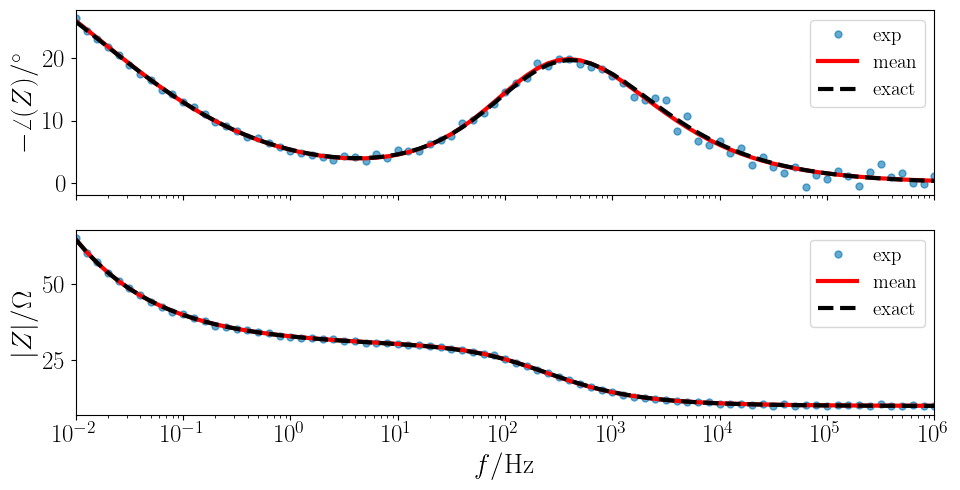

In [14]:
# Compute the posterior mean impedance
Z_mean = np.mean(sum_of_arcs_impedance, axis=0)

# Prepare magnitude (Ohms) and phase (degrees) for each quantity
mag_exp   = np.abs(Z_exp)
mag_exact = np.abs(Z_exact)
mag_mean  = np.abs(Z_mean)

phase_exp   = np.angle(Z_exp, deg=True)
phase_exact = np.angle(Z_exact, deg=True)
phase_mean  = np.angle(Z_mean, deg=True)

fig, (ax_phase, ax_mag) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5.3), sharex=True)
plt.subplots_adjust(hspace=0.05)
# Phase
ax_phase.semilogx(freq_vec, -phase_exp,   'o',  label='exp',   alpha=0.6, markersize=5)
ax_phase.semilogx(freq_vec, -phase_mean,  'r-', label='mean',  linewidth=3)
ax_phase.semilogx(freq_vec, -phase_exact, 'k--',label='exact', linewidth=3)
# ax_phase.set_xlabel(r'$f/\mathrm{Hz}$')
ax_phase.set_xlim(1e-2,1e6)
ax_phase.set_ylabel(r'$-\angle(Z)/^\circ$')
ax_phase.legend(frameon=True, framealpha=0.75, fontsize=14)

# Magnitude
ax_mag.semilogx(freq_vec, mag_exp,   'o',  label='exp',   alpha=0.6, markersize=5)
ax_mag.semilogx(freq_vec, mag_mean,  'r-', label='mean',  linewidth=3)
ax_mag.semilogx(freq_vec, mag_exact, 'k--',label='exact', linewidth=3)
ax_mag.set_xlabel(r'$f/\mathrm{Hz}$')
ax_mag.set_ylabel(r'$|Z|/\Omega$')
ax_mag.legend(frameon=True, framealpha=0.75, fontsize=14)

plt.tight_layout()
# plt.savefig('bode_fit.png', format='png', dpi=300)
# plt.savefig('bode_fit.svg',)
plt.show()